In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from visualization import TrainingVisualizer

In [2]:
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 加载文本数据
with open('data/time_machine_txt/timemachine.txt', 'r') as f:
    text = f.read()

# 创建字符映射表
chars = sorted(list(set(text)))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for idx, ch in enumerate(chars)}

# 转换文本为索引
text_as_int = np.array([char_to_idx[c] for c in text])

In [4]:
# 定义超参数
seq_length = 100  # 序列长度 - 一个句子100个字符
batch_size = 256
hidden_size = 256
embedding_dim = 64  # input_size 嵌入向量的大小
num_layers = 1
learning_rate = 0.001
num_epochs = 20
vocab_size = len(chars)  # 字符的个数

def create_dataset(text_as_int, seq_length, batch_size):
    sequences = []
    targets = []
    for i in range(0, len(text_as_int) - seq_length):
        sequences.append(text_as_int[i:i + seq_length])
        targets.append(text_as_int[i + 1:i + seq_length + 1])
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(sequences, targets)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

dataloader = create_dataset(text_as_int, seq_length, batch_size)

C:\Users\20703\AppData\Local\Temp\ipykernel_14032\1556026959.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  sequences = torch.tensor(sequences, dtype=torch.long)


In [5]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = out.contiguous().view(-1, hidden[0].size(2))
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(num_layers, batch_size, hidden_size).to(device),
                torch.zeros(num_layers, batch_size, hidden_size).to(device))

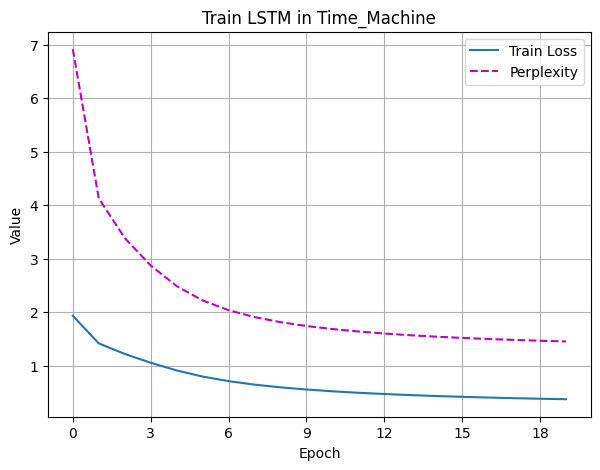

In [7]:
num_epochs = 20

# 实例化模型
model = LSTMModel(vocab_size, embedding_dim, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
visualizer = TrainingVisualizer(xlabel='Epoch', ylabel='Value', title='Train LSTM in Time_Machine', legend=['Train Loss', 'Perplexity'])

# 训练模型并计算困惑度
for epoch in range(num_epochs):
    total_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        current_batch_size = inputs.size(0)
        inputs = inputs.view(current_batch_size, -1).to(device)
        targets = targets.view(-1).to(device)

        optimizer.zero_grad()
        hidden = model.init_hidden(current_batch_size)
        output, hidden = model(inputs, hidden)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    perplexity = torch.exp(torch.tensor(avg_loss))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}')

    visualizer.add(epoch, [avg_loss, perplexity.item()])

In [8]:
# 生成文本
def generate_text(model, start_str, length):
    model.eval()
    hidden = model.init_hidden(1)
    input = torch.tensor([char_to_idx[ch] for ch in start_str], dtype=torch.long).unsqueeze(0).to(device)

    generated_text = start_str
    for _ in range(length):
        output, hidden = model(input, hidden)
        _, top_idx = torch.topk(output[-1], 1)
        next_char = idx_to_char[top_idx.item()]
        generated_text += next_char
        input = torch.tensor([[top_idx]], dtype=torch.long).to(device)
    
    return generated_text

# 生成文本示例
start_str = "Filby became pensive. "
generated_text = generate_text(model, start_str, 100)
print(generated_text)

Filby became pensive. 'Clearly,' the Time Traveller pushed his glass towards the new real. I thinking (after the easy reco
